In [1]:
import json
import numpy as np
import pandas as pd
from superlink.superlink import SuperLink
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
sns.set_palette('husl')
%matplotlib inline

In [2]:
with open('../data/six_pipes.json', 'r') as j:
    inp = json.load(j)
    
superjunctions = pd.DataFrame(inp['superjunctions'])
superlinks = pd.DataFrame(inp['superlinks'])
junctions = pd.DataFrame(inp['junctions'])
links = pd.DataFrame(inp['links'])

superjunctions['h_0'] += 1e-5
junctions['h_0'] += 1e-5
links['Q_0'] += 0

# Simulation with additive Gaussian noise

In [3]:
superlink = SuperLink(superlinks, superjunctions, links, junctions, dt=1e-6)    

In [4]:
t = 0
dt = 30
dHdt = 1 / 60 / 60
bc = superlink.bc.astype(float)
H_bc = np.copy(superlink.H_j)
Q_0j = np.zeros(H_bc.size)
h = {}
H = {}
Qu = {}
Qd = {}
ts = []
Qins = []
Hbs = []

for _ in range(2 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j_c = Q_0j + 0.05*np.random.randn(Q_0j.size)
    superlink.step(H_bc=H_bc, dt=dt, Q_0j=Q_0j_c)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j_c)
    
dHdt = -2.5 / 240 / 60
dQdt = np.array([0.5, 0, 0.3, 0, 0, 0]) / 60 / 60

for _ in range(1 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j = Q_0j + dQdt * dt
    Q_0j_c = Q_0j + 0.05*np.random.randn(Q_0j.size)
    superlink.step(H_bc=H_bc, dt=dt, Q_0j=Q_0j_c)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j_c)

for _ in range(1 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j = Q_0j - dQdt * dt
    Q_0j_c = Q_0j + 0.05*np.random.randn(Q_0j.size)
    superlink.step(H_bc=H_bc, dt=dt, Q_0j=Q_0j_c)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j_c)
    
Q_0j = np.zeros(H_bc.size)

for _ in range(2 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j_c = Q_0j + 0.05*np.random.randn(Q_0j.size)
    superlink.step(H_bc=H_bc, dt=dt, Q_0j=Q_0j_c)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j_c)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [5]:
Q = (np.vstack(Qu.values()) + np.vstack(Qd.values())) / 2

In [6]:
H = np.vstack(H.values())

In [7]:
ts = np.asarray(ts)

In [8]:
Qin = np.vstack(Qins)

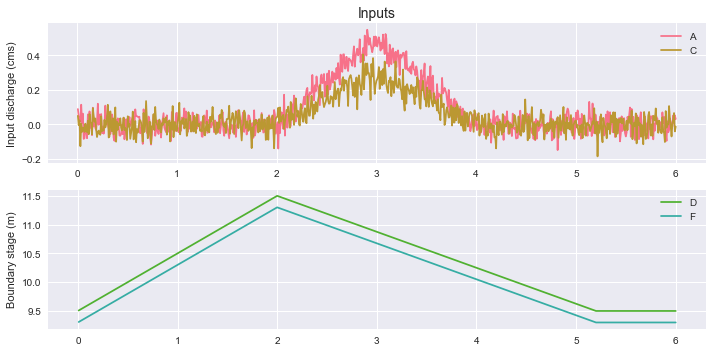

In [9]:
fig, ax = plt.subplots(2, figsize=(10, 5))
ax[0].plot(ts / 3600, Qin[:,0], label='A')
ax[0].plot(ts / 3600, Qin[:,2], label='C')
ax[0].set_title('Inputs')
ax[0].set_ylabel('Input discharge (cms)')
ax[0].legend()
ax[1].plot([0], [10])
ax[1].plot([0], [10])
ax[1].plot(ts / 3600, H[:,3], label='D')
ax[1].plot(ts / 3600, H[:,5], label='F')
ax[0].set_title('Inputs', size=14)
ax[1].set_ylabel('Boundary stage (m)')
ax[1].legend()
plt.tight_layout()

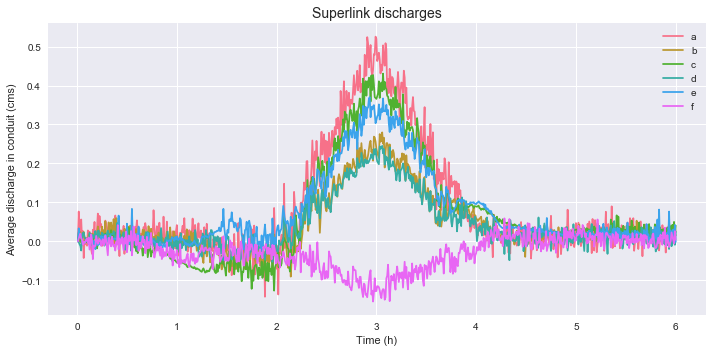

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(ts / 3600, Q[:,0], label='a')
plt.plot(ts / 3600, Q[:,1], label='b')
plt.plot(ts / 3600, Q[:,2], label='c')
plt.plot(ts / 3600, Q[:,3], label='d')
plt.plot(ts / 3600, Q[:,4], label='e')
plt.plot(ts / 3600, Q[:,5], label='f')
plt.title('Superlink discharges', size=14)
plt.xlabel('Time (h)')
plt.ylabel('Average discharge in conduit (cms)')
plt.legend()
plt.tight_layout()

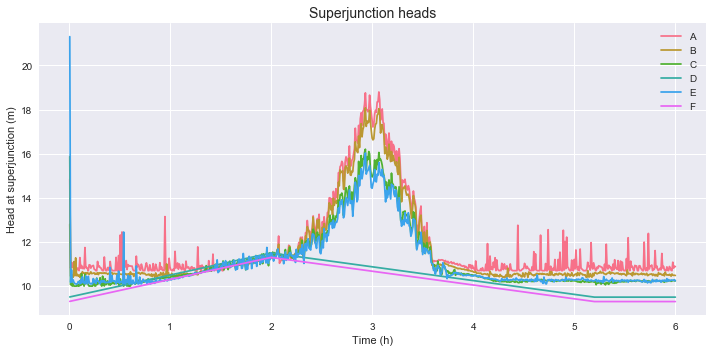

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(ts / 3600, H[:,0], label='A')
plt.plot(ts / 3600, H[:,1], label='B')
plt.plot(ts / 3600, H[:,2], label='C')
plt.plot(ts / 3600, H[:,3], label='D')
plt.plot(ts / 3600, H[:,4], label='E')
plt.plot(ts / 3600, H[:,5], label='F')
plt.title('Superjunction heads', size=14)
plt.xlabel('Time (h)')
plt.ylabel('Head at superjunction (m)')
plt.legend()
plt.tight_layout()

# Use a "clean" simulation as observations

In [12]:
superlink = SuperLink(superlinks, superjunctions, links, junctions, dt=1e-6)    

In [13]:
t = 0
dt = 30
dHdt = 1 / 60 / 60
bc = superlink.bc.astype(float)
H_bc = np.copy(superlink.H_j)
Q_0j = np.zeros(H_bc.size)
h = {}
H = {}
Qu = {}
Qd = {}
ts = []
Qins = []
Hbs = []

for _ in range(2 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    superlink.step(H_bc=H_bc, dt=dt)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)
    
dHdt = -2.5 / 240 / 60
dQdt = np.array([0.5, 0, 0.3, 0, 0, 0]) / 60 / 60

for _ in range(1 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j = Q_0j + dQdt * dt
    superlink.step(H_bc=H_bc, dt=dt, Q_0j=Q_0j)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)

for _ in range(1 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j = Q_0j - dQdt * dt
    superlink.step(H_bc=H_bc, dt=dt, Q_0j=Q_0j)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)
    
for _ in range(2 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    superlink.step(H_bc=H_bc, dt=dt)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [14]:
Z = np.vstack(H.values())

# Apply implicit Kalman filter

In [15]:
superlink = SuperLink(superlinks, superjunctions, links, junctions, dt=1e-6)    

In [16]:
i = 0
t = 0
dt = 30
dHdt = 1 / 60 / 60
bc = superlink.bc.astype(float)
H_bc = np.copy(superlink.H_j)
Q_0j = np.zeros(H_bc.size)
hs = {}
Hs = {}
Qus = {}
Qds = {}
ts = []
Qins = []
Hbs = []

In [17]:
H = np.eye(Q_0j.size)
Qcov = (0.05**2)*np.eye(Q_0j.size)
Rcov = (0.01**2)*np.eye(Q_0j.size)
C = np.eye(Q_0j.size)
P = C @ Qcov @ C.T
I = np.eye(Q_0j.size)

P_k_k = P

In [18]:
for _ in range(2 * 3600 // dt):
    i += 1
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j_c = Q_0j + 0.05*np.random.randn(Q_0j.size)
    superlink.link_hydraulic_geometry()
    superlink.compute_storage_areas()
    superlink.node_velocities()
    superlink.link_coeffs(_dt=dt)
    superlink.node_coeffs(_dt=dt)
    superlink.forward_recurrence()
    superlink.backward_recurrence()
    superlink.superlink_upstream_head_coefficients()
    superlink.superlink_downstream_head_coefficients()
    superlink.superlink_flow_coefficients()
    superlink.sparse_matrix_equations(H_bc=H_bc, _Q_0j=Q_0j_c,
                                      first_time=False, _dt=dt)
    superlink.solve_sparse_matrix()
    # Start filtering
    b = superlink.b
    A_1 = superlink.A.tocsc()
    A_2 = np.diag(np.where(~bc.astype(bool), superlink._A_sj / dt, 0))
    y_k1_k = b
    H_1 = H @ scipy.sparse.linalg.inv(A_1)
    P_k1_k = A_2 @ P_k_k @ A_2.T + C @ Qcov @ C.T
    L_k1 = P_k1_k @ H_1.T @ np.linalg.inv(H_1 @ P_k1_k @ H_1.T + Rcov)
    P_k1_k1 = (I - L_k1 @ H_1) @ P_k1_k
    b_hat = y_k1_k + L_k1 @ (Z[i-1] - H_1 @ y_k1_k)
    superlink.b = b_hat
    superlink.solve_sparse_matrix()
    superlink.solve_superlink_flows()
    superlink.solve_superlink_depths_alt()
    superlink.solve_internals_lsq()
    P_k_k = P_k1_k1
    hs[t] = np.copy(superlink._h_Ik)
    Hs[t] = superlink.H_j
    Qus[t] = superlink._Q_uk
    Qds[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [19]:
dHdt = -2.5 / 240 / 60
dQdt = np.array([0.5, 0, 0.3, 0, 0, 0]) / 60 / 60

In [20]:
for _ in range(1 * 3600 // dt):
    i += 1
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j = Q_0j + dQdt * dt
    Q_0j_c = Q_0j + 0.05*np.random.randn(Q_0j.size)
    superlink.link_hydraulic_geometry()
    superlink.compute_storage_areas()
    superlink.node_velocities()
    superlink.link_coeffs(_dt=dt)
    superlink.node_coeffs(_dt=dt)
    superlink.forward_recurrence()
    superlink.backward_recurrence()
    superlink.superlink_upstream_head_coefficients()
    superlink.superlink_downstream_head_coefficients()
    superlink.superlink_flow_coefficients()
    superlink.sparse_matrix_equations(H_bc=H_bc, _Q_0j=Q_0j_c,
                                      first_time=False, _dt=dt)
    superlink.solve_sparse_matrix()
    # Start filtering
    b = superlink.b
    A_1 = superlink.A.tocsc()
    A_2 = np.diag(np.where(~bc.astype(bool), superlink._A_sj / dt, 0))
    y_k1_k = b
    H_1 = H @ scipy.sparse.linalg.inv(A_1)
    P_k1_k = A_2 @ P_k_k @ A_2.T + C @ Qcov @ C.T
    L_k1 = P_k1_k @ H_1.T @ np.linalg.inv(H_1 @ P_k1_k @ H_1.T + Rcov)
    P_k1_k1 = (I - L_k1 @ H_1) @ P_k1_k
    b_hat = y_k1_k + L_k1 @ (Z[i-1] - H_1 @ y_k1_k)
    superlink.b = b_hat
    superlink.solve_sparse_matrix()
    superlink.solve_superlink_flows()
    superlink.solve_superlink_depths_alt()
    superlink.solve_internals_lsq()
    P_k_k = P_k1_k1
    hs[t] = np.copy(superlink._h_Ik)
    Hs[t] = superlink.H_j
    Qus[t] = superlink._Q_uk
    Qds[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [21]:
for _ in range(1 * 3600 // dt):
    i += 1
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j = Q_0j - dQdt * dt
    Q_0j_c = Q_0j + 0.05*np.random.randn(Q_0j.size)
    superlink.link_hydraulic_geometry()
    superlink.compute_storage_areas()
    superlink.node_velocities()
    superlink.link_coeffs(_dt=dt)
    superlink.node_coeffs(_dt=dt)
    superlink.forward_recurrence()
    superlink.backward_recurrence()
    superlink.superlink_upstream_head_coefficients()
    superlink.superlink_downstream_head_coefficients()
    superlink.superlink_flow_coefficients()
    superlink.sparse_matrix_equations(H_bc=H_bc, _Q_0j=Q_0j_c,
                                      first_time=False, _dt=dt)
    superlink.solve_sparse_matrix()
    # Start filtering
    b = superlink.b
    A_1 = superlink.A.tocsc()
    A_2 = np.diag(np.where(~bc.astype(bool), superlink._A_sj / dt, 0))
    y_k1_k = b
    H_1 = H @ scipy.sparse.linalg.inv(A_1)
    P_k1_k = A_2 @ P_k_k @ A_2.T + C @ Qcov @ C.T
    L_k1 = P_k1_k @ H_1.T @ np.linalg.inv(H_1 @ P_k1_k @ H_1.T + Rcov)
    P_k1_k1 = (I - L_k1 @ H_1) @ P_k1_k
    b_hat = y_k1_k + L_k1 @ (Z[i-1] - H_1 @ y_k1_k)
    superlink.b = b_hat
    superlink.solve_sparse_matrix()
    superlink.solve_superlink_flows()
    superlink.solve_superlink_depths_alt()
    superlink.solve_internals_lsq()
    P_k_k = P_k1_k1
    hs[t] = np.copy(superlink._h_Ik)
    Hs[t] = superlink.H_j
    Qus[t] = superlink._Q_uk
    Qds[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [22]:
Q_0j = np.zeros(H_bc.size)

for _ in range(2 * 3600 // dt):
    i += 1
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j_c = Q_0j + 0.05*np.random.randn(Q_0j.size)
    superlink.link_hydraulic_geometry()
    superlink.compute_storage_areas()
    superlink.node_velocities()
    superlink.link_coeffs(_dt=dt)
    superlink.node_coeffs(_dt=dt)
    superlink.forward_recurrence()
    superlink.backward_recurrence()
    superlink.superlink_upstream_head_coefficients()
    superlink.superlink_downstream_head_coefficients()
    superlink.superlink_flow_coefficients()
    superlink.sparse_matrix_equations(H_bc=H_bc, _Q_0j=Q_0j_c,
                                      first_time=False, _dt=dt)
    superlink.solve_sparse_matrix()
    # Start filtering
    b = superlink.b
    A_1 = superlink.A.tocsc()
    A_2 = np.diag(np.where(~bc.astype(bool), superlink._A_sj / dt, 0))
    y_k1_k = b
    H_1 = H @ scipy.sparse.linalg.inv(A_1)
    P_k1_k = A_2 @ P_k_k @ A_2.T + C @ Qcov @ C.T
    L_k1 = P_k1_k @ H_1.T @ np.linalg.inv(H_1 @ P_k1_k @ H_1.T + Rcov)
    P_k1_k1 = (I - L_k1 @ H_1) @ P_k1_k
    b_hat = y_k1_k + L_k1 @ (Z[i-1] - H_1 @ y_k1_k)
    superlink.b = b_hat
    superlink.solve_sparse_matrix()
    superlink.solve_superlink_flows()
    superlink.solve_superlink_depths_alt()
    superlink.solve_internals_lsq()
    P_k_k = P_k1_k1
    hs[t] = np.copy(superlink._h_Ik)
    Hs[t] = superlink.H_j
    Qus[t] = superlink._Q_uk
    Qds[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [23]:
Qs = (np.vstack(Qus.values()) + np.vstack(Qds.values())) / 2
Hs = np.vstack(Hs.values())
ts = np.asarray(ts)
Qins = np.vstack(Qins)

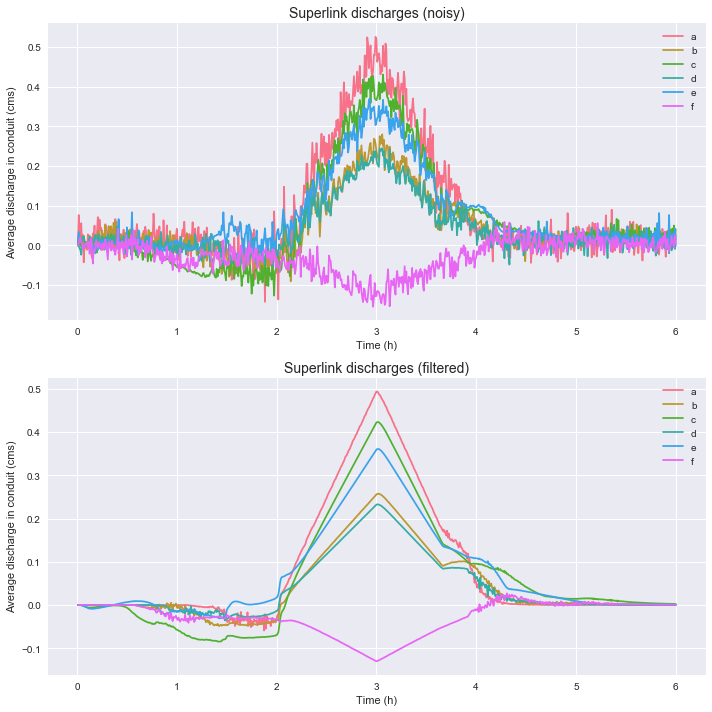

In [24]:
fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].plot(ts / 3600, Q[:,0], label='a')
ax[0].plot(ts / 3600, Q[:,1], label='b')
ax[0].plot(ts / 3600, Q[:,2], label='c')
ax[0].plot(ts / 3600, Q[:,3], label='d')
ax[0].plot(ts / 3600, Q[:,4], label='e')
ax[0].plot(ts / 3600, Q[:,5], label='f')
ax[0].set_title('Superlink discharges (noisy)', size=14)
ax[0].set_xlabel('Time (h)')
ax[0].set_ylabel('Average discharge in conduit (cms)')
ax[0].legend()
ax[1].plot(ts / 3600, Qs[:,0], label='a')
ax[1].plot(ts / 3600, Qs[:,1], label='b')
ax[1].plot(ts / 3600, Qs[:,2], label='c')
ax[1].plot(ts / 3600, Qs[:,3], label='d')
ax[1].plot(ts / 3600, Qs[:,4], label='e')
ax[1].plot(ts / 3600, Qs[:,5], label='f')
ax[1].set_title('Superlink discharges (filtered)', size=14)
ax[1].set_xlabel('Time (h)')
ax[1].set_ylabel('Average discharge in conduit (cms)')
ax[1].legend()
plt.tight_layout()